## 1. 导入相关库

In [1]:
import os
import re
import jieba
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import torch
from transformers import BertTokenizer, BertForTokenClassification
import sklearn_crfsuite
from sklearn_crfsuite import metrics
from seqeval.metrics import classification_report

# 设置绘图字体，解决中文显示问题
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

D:\anaconda3\envs\nlp\lib\site-packages\jieba\_compat.py:18: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
D:\anaconda3\envs\nlp\lib\site-packages\torch\cuda\__init__.py:63: FutureWarning: The pynvml package is deprecated. Please install nvidia-ml-py instead. If you did not install pynvml directly, please report this to the maintainers of the package that installed pynvml for you.
  import pynvml  # type: ignore[import]
D:\anaconda3\envs\nlp\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 2. 基于词典的算法分词实现

### 2.1 构建词典

In [2]:
def build_dict_from_file(file_path, encoding='utf-8'):
    """从文件读取词语并构建词典集合"""
    word_dict = set()
    try:
        with open(file_path, 'r', encoding=encoding) as f:
            for line in f:
                word = line.strip().split('\t')[0]  # 根据字典格式设置
                if word:
                    word_dict.add(word)
    except Exception as e:
        print(f"读取词典文件出错: {e}")
        # 创建一个简单的词典作为备用
        word_dict = {"中国", "人民", "共和国", "北京", "天安门", "计算机", "科学", "自然语言", "处理"}
    
    return word_dict


def read_bio_file(file_path, encoding="utf-8"):
    """ 读取 BIO 格式数据 """
    sentences = []
    labels = []

    sent_chars = []
    sent_labels = []

    with open(file_path, encoding=encoding) as f:
        for line in f:
            line = line.strip()
            if not line:
                if sent_chars:
                    sentences.append(sent_chars)
                    labels.append(sent_labels)
                    sent_chars = []
                    sent_labels = []
                continue

            # 兼容可能的空格分隔（原代码是\t分隔，增加兼容性）
            parts = line.split() if '\t' not in line else line.split('\t')
            if len(parts) != 2:
                continue  # 跳过格式错误的行
            char, tag = parts
            sent_chars.append(char)
            sent_labels.append(tag)

    if sent_chars:
        sentences.append(sent_chars)
        labels.append(sent_labels)

    return sentences, labels

def bio_to_segmentation(chars, labels):
    """ 将 BIO 标签序列转换为分词结果 """
    segmentation = []
    current_word = []
    for char, label in zip(chars, labels):
        if label.startswith('B-'):
            if current_word:
                segmentation.append(''.join(current_word))
            current_word = [char]
        elif label.startswith('I-'):
            current_word.append(char)
        else:  # O标签，单个字符
            if current_word:
                segmentation.append(''.join(current_word))
                current_word = []
            segmentation.append(char)
    # 处理最后一个词
    if current_word:
        segmentation.append(''.join(current_word))
    return segmentation
 
# 构建词典
# word_dict = build_dict_from_file('ci_word_dict.txt')
word_dict = build_dict_from_file('news_word_dict.txt')
print(f"词典大小: {len(word_dict)}")
print(f"词典示例: {list(word_dict)[:10]}")

print("正在读取测试集...")
test_sentences, test_labels = read_bio_file("test.txt")

gold_segmentations = [bio_to_segmentation(chars, labels) for chars, labels in zip(test_sentences, test_labels)]

词典大小: 49907
词典示例: ['易文', '中欧', '狱中', '友顺', '水球赛', '撩开', '话别', '见习', '君士坦丁堡', '俯视']
正在读取测试集...


### 2.2 实现正向最大匹配算法

In [3]:
def fmm_segment(texts, word_dict, max_word_len=5):
    """正向最大匹配算法 (FMM)"""
    processed_texts = []
    for text in texts:
        if isinstance(text, (list, tuple)):
            processed_texts.append(''.join(text))
        else:
            processed_texts.append(str(text))

    result = []
    for text in processed_texts:
        words = []
        i = 0
        while i < len(text):
            matched = False
            for length in range(max_word_len, 0, -1):
                if i + length > len(text):
                    continue
                word = text[i : i + length]
                if word in word_dict:
                    words.append(word)
                    i += length
                    matched = True
                    break
            if not matched:  # 未匹配，按字符切分
                words.append(text[i])
                i += 1
        result.append(words)
    return result

# 测试FMM算法
# test_text = "自然语言处理是计算机科学的一个重要分支"
fmm_result = fmm_segment(test_sentences, word_dict)
print(f"FMM分词结果: {fmm_result[0]}")

FMM分词结果: ['中共中央', '致中', '国', '致公党', '十一', '大', '的', '贺词', '各位', '代表', '、', '各位', '同志', '：', '在', '中国', '致公党', '第十一', '次', '全国', '代表大会', '隆重', '召开', '之际', '，', '中国', '共产党', '中央委员', '会', '谨', '向', '大会', '表示', '热烈', '的', '祝贺', '，', '向', '致公党', '的', '同志', '们', '致以', '亲切', '的', '问候', '！']


### 2.3 实现逆向最大匹配算法

In [4]:
def bmm_segment(texts, word_dict, max_word_len=5):
    """逆向最大匹配算法 (BMM)"""
    processed_texts = []
    for text in texts:
        if isinstance(text, (list, tuple)):
            processed_texts.append(''.join(text))
        else:
            processed_texts.append(str(text))

    result = []
    for text in processed_texts:
        words = []
        i = len(text)
        while i > 0:
            matched = False
            for length in range(max_word_len, 0, -1):
                if i - length < 0:
                    continue
                word = text[i - length:i]
                if word in word_dict:
                    words.insert(0, word)
                    i -= length
                    matched = True
                    break
            if not matched:  # 未匹配，按字符切分
                words.insert(0, text[i - 1])
                i -= 1
        result.append(words)
    return result
 
# 测试BMM算法
bmm_result = bmm_segment(test_sentences, word_dict)
print(f"BMM分词结果: {bmm_result[0]}")

BMM分词结果: ['中共中央', '致', '中国', '致公党', '十一', '大', '的', '贺词', '各位', '代表', '、', '各位', '同志', '：', '在', '中国', '致公党', '第十一', '次', '全国', '代表大会', '隆重', '召开', '之际', '，', '中', '国共', '产', '党中央', '委员会', '谨', '向', '大会', '表示', '热烈', '的', '祝贺', '，', '向', '致公党', '的', '同志', '们', '致以', '亲切', '的', '问候', '！']


### 2.4 实现双向最大匹配算法

In [5]:
def bimm_segment(texts, word_dict, max_word_len=5):
    """双向最大匹配算法 (BIMM)"""
    fmm_result = fmm_segment(texts, word_dict, max_word_len)
    bmm_result = bmm_segment(texts, word_dict, max_word_len)
    
    # 分词数不同，取分词数量较少的
    if len(fmm_result) != len(bmm_result):
        return fmm_result if len(fmm_result) < len(bmm_result) else bmm_result
    
    # 分词数量相同，返回单字较少的
    fmm_single_word_count = sum(1 for word in fmm_result if len(word) == 1)
    bmm_single_word_count = sum(1 for word in bmm_result if len(word) == 1)
    
    return fmm_result if fmm_single_word_count < bmm_single_word_count else bmm_result
 
# 测试BIMM算法
bimm_result = bimm_segment(test_sentences, word_dict)
print(f"BIMM分词结果: {bimm_result[0]}")

BIMM分词结果: ['中共中央', '致', '中国', '致公党', '十一', '大', '的', '贺词', '各位', '代表', '、', '各位', '同志', '：', '在', '中国', '致公党', '第十一', '次', '全国', '代表大会', '隆重', '召开', '之际', '，', '中', '国共', '产', '党中央', '委员会', '谨', '向', '大会', '表示', '热烈', '的', '祝贺', '，', '向', '致公党', '的', '同志', '们', '致以', '亲切', '的', '问候', '！']


## 3. 统计分词方法

### 3.1使用 HMM 进行中文分词

In [6]:
def train_hmm_from_corpus(corpus_file, encoding='utf-8'):
    """
    从语料库训练 HMM 模型
    
    parm [output] A: 状态转移概率矩阵
    parm [output] B: 发射概率矩阵
    parm [output] pi: 初始状态概率向量
    """
    # 定义状态: B(开始), M(中间), E(结束), S(单字)
    states = ['B', 'M', 'E', 'S']
    
    # 计数器初始化
    state_count = {state: 0 for state in states}
    transition_count = {state: {next_state: 0 for next_state in states} for state in states}
    emission_count = {state: {} for state in states}
    
    # 尝试读取文件，处理编码问题
    file_read_success = False
    candidate_encodings = ['utf-8', 'gbk', 'gb2312', 'gb18030']
    
    # 如果指定了编码，先尝试指定的编码
    if encoding:
        try:
            with open(corpus_file, 'r', encoding=encoding) as f:
                process_corpus_lines(f, state_count, transition_count, emission_count)
            file_read_success = True
        except Exception as e:
            print(f"使用编码 {encoding} 读取失败: {e}")
    
    # 如果指定编码失败，尝试其他候选编码
    if not file_read_success:
        for enc in candidate_encodings:
            if enc == encoding:  # 跳过已经尝试过的编码
                continue
            try:
                with open(corpus_file, 'r', encoding=enc) as f:
                    process_corpus_lines(f, state_count, transition_count, emission_count)
                file_read_success = True
                print(f"成功使用编码 {enc} 读取文件")
                break
            except Exception as e:
                continue
    
    # 如果所有编码都失败，抛出异常
    if not file_read_success:
        raise ValueError("无法读取文件，请检查文件路径或指定正确的编码")
    
    # 计算概率（添加拉普拉斯平滑避免零概率）
    smooth_factor = 1e-6  # 平滑因子
    total_states = len(states)
    
    # 计算状态转移概率矩阵 A
    A = {}
    for state in states:
        A[state] = {}
        total_transitions = sum(transition_count[state].values())
        # 拉普拉斯平滑：分子+1，分母+状态数
        for next_state in states:
            numerator = transition_count[state][next_state] + smooth_factor
            denominator = total_transitions + total_states * smooth_factor
            A[state][next_state] = numerator / denominator if denominator > 0 else 0
    
    # 计算发射概率矩阵 B
    B = {}
    for state in states:
        B[state] = {}
        total_emissions = state_count[state]
        # 获取所有出现过的字符
        all_chars = set()
        for s in states:
            all_chars.update(emission_count[s].keys())
        total_chars = len(all_chars)
        
        # 拉普拉斯平滑
        for char in all_chars:
            count = emission_count[state].get(char, 0)
            numerator = count + smooth_factor
            denominator = total_emissions + total_chars * smooth_factor
            B[state][char] = numerator / denominator if denominator > 0 else 0
    
    # 计算初始状态概率向量 pi
    pi = {}
    total_count = sum(state_count.values())
    for state in states:
        numerator = state_count[state] + smooth_factor
        denominator = total_count + total_states * smooth_factor
        pi[state] = numerator / denominator if denominator > 0 else 1.0 / total_states
    
    return A, B, pi

def preprocess_corpus(input_file, output_file, encoding='utf-8'):
    with open(input_file, 'r', encoding=encoding) as f_in, open(output_file, 'w', encoding='utf-8') as f_out:
        for line in f_in:
            line = line.strip()
            if not line:
                continue
            # 处理 "词语/词性" 或 "词语 词性" 格式，仅提取词语
            words = []
            for token in line.split():
                # 分割 / 或 空格，取第一个部分作为词语
                word = token.split('/')[0].strip() if '/' in token else token.strip()
                if word:  # 过滤空词语
                    words.append(word)
            # 写入处理后的句子（词语用空格分隔）
            f_out.write(' '.join(words) + '\n')

def process_corpus_lines(file_object, state_count, transition_count, emission_count):
    """ 处理语料库的每一行，更新计数器 """
    for line in file_object:
        line = line.strip()
        if not line:
            continue
        
        # 处理已分词的语料（默认用空格分隔）
        words = line.split()
        prev_state = None  # 上一个状态，用于计算转移概率
        
        for word in words:
            word_len = len(word)
            
            # 更新发射概率计数器和状态计数器
            if word_len == 1:
                # 单字状态 S
                state = 'S'
                state_count[state] += 1
                # 更新发射计数
                char = word[0]
                if char not in emission_count[state]:
                    emission_count[state][char] = 0
                emission_count[state][char] += 1
                
                # 更新转移概率（从上一个状态到当前状态）
                if prev_state is not None:
                    transition_count[prev_state][state] += 1
                prev_state = state
            
            else:
                # 多字词语：B -> M* -> E
                # 第一个字符：B状态
                state = 'B'
                state_count[state] += 1
                char = word[0]
                if char not in emission_count[state]:
                    emission_count[state][char] = 0
                emission_count[state][char] += 1
                
                # 更新转移概率（从上一个状态到B）
                if prev_state is not None:
                    transition_count[prev_state][state] += 1
                prev_state = state
                
                # 中间字符：M状态（如果词语长度>2）
                for i in range(1, word_len - 1):
                    state = 'M'
                    state_count[state] += 1
                    char = word[i]
                    if char not in emission_count[state]:
                        emission_count[state][char] = 0
                    emission_count[state][char] += 1
                    
                    # 更新转移概率（从 B 或 M 到 M）
                    transition_count[prev_state][state] += 1
                    prev_state = state
                
                # 最后一个字符：E 状态
                state = 'E'
                state_count[state] += 1
                char = word[-1]
                if char not in emission_count[state]:
                    emission_count[state][char] = 0
                emission_count[state][char] += 1
                
                # 更新转移概率（从 M 到 E）
                transition_count[prev_state][state] += 1
                prev_state = state


 
def viterbi_segment(texts, A, B, pi):
    """
    使用维特比算法进行隐马尔可夫分词
    
    parm text: 待分词文本
    parm A: 状态转移概率矩阵
    parm B: 发射概率矩阵
    parm pi: 初始状态概率向量
    parm [output] word: 分词结果列表
    """
    processed_texts = []
    for text in texts:
        if isinstance(text, (list, tuple)):
            processed_texts.append(''.join(text))
        else:
            processed_texts.append(str(text))

    result = []
    for text in processed_texts:
        states = ['B', 'M', 'E', 'S']
    
        # 初始化
        V = [{}]
        path = {}
    
        # 初始状态
        for state in states:
            V[0][state] = pi[state] * B[state].get(text[0], 1e-10)
            path[state] = [state]
    
        # 递推
        for t in range(1, len(text)):
            V.append({})
            new_path = {}
        
            for curr_state in states:
                max_prob = -1
                max_state = None
            
                for prev_state in states:
                    prob = V[t-1][prev_state] * A[prev_state].get(curr_state, 1e-10) * B[curr_state].get(text[t], 1e-10)
                
                    if prob > max_prob:
                        max_prob = prob
                        max_state = prev_state
                
                V[t][curr_state] = max_prob
                new_path[curr_state] = path[max_state] + [curr_state]
        
            path = new_path
    
        # 找出最可能的状态序列
        max_prob = -1
        max_state = None
    
        for state in states:
            if V[len(text)-1][state] > max_prob:
                max_prob = V[len(text)-1][state]
                max_state = state
        
        state_sequence = path[max_state]
        
        # 根据状态序列分词
        words = []
        word = ""
        for i, state in enumerate(state_sequence):
            if state == 'B' or state == 'M':
                word += text[i]
            elif state == 'E':
                word += text[i]
                words.append(word)
                word = ""
            else:  # state == 'S'
                words.append(text[i])
        
        # 处理可能的剩余字符
        if word:
            words.append(word)
        
        result.append(words)
    return result

preprocess_corpus("1998-01-2003版-带音.txt", "processed_corpus.txt", encoding="utf-8")
A, B, pi = train_hmm_from_corpus("processed_corpus.txt", encoding="utf-8")
# 测试 HMM 分词
hmm_result = viterbi_segment(test_sentences, A, B, pi)
print(f"HMM分词结果: {hmm_result[0]}")

HMM分词结果: ['中共', '中央', '致中', '国致', '公党', '十', '一大', '的', '贺词', '各位', '代表', '、', '各位', '同志', '：', '在', '中', '国致', '公党', '第十', '一次', '全国', '代表', '大会', '隆重', '召开', '之际', '，', '中国', '共产', '党', '中央', '委员', '会谨', '向', '大会', '表示', '热烈', '的', '祝贺', '，', '向', '致', '公党', '的', '同志', '们', '致以', '亲切', '的', '问候', '！']


### 3.2 使用 CRF 进行中文分词

In [7]:
import random

def prepare_crf_data(sentences):
    """ 准备CRF模型训练数据 """
    X = []
    y = []
    
    for sentence in sentences:
        chars = []
        labels = []
        
        for word in sentence:
            if len(word) == 1:
                chars.append(word)
                labels.append('S')
            else:
                chars.append(word[0])
                labels.append('B')
                
                for char in word[1:-1]:
                    chars.append(char)
                    labels.append('M')
                
                chars.append(word[-1])
                labels.append('E')
        
        X.append([word2features(chars, i) for i in range(len(chars))])
        y.append(labels)
    
    return X, y
 
def word2features(sent, i):
    """为 CRF 提取当前字符及其上下文的特征"""
    char = sent[i]
    features = {'bias': 1.0, 'char': char}
    if i > 0: # 前一个字符
        features.update({'-1:char': sent[i-1], 'bi:-1': sent[i-1]+char})
    if i < len(sent) - 1: # 后一个字符
        features.update({'+1:char': sent[i+1], 'bi:+1': char+sent[i+1]})
    return features
 
def crf_segment(texts, crf_model):
    """ 使用CRF模型进行分词 """
    processed_texts = []
    for text in texts:
        if isinstance(text, (list, tuple)):
            processed_texts.append(''.join(text))
        else:
            processed_texts.append(str(text))

    result = []
    for text in processed_texts:
        chars = list(text)
        features = [word2features(chars, i) for i in range(len(chars))]
        labels = crf_model.predict([features])[0]
    
        words = []
        word = ""
        for i, label in enumerate(labels):
            if label == 'B':
                if word:
                    words.append(word)
                word = chars[i]
            elif label == 'M':
                word += chars[i]
            elif label == 'E':
                word += chars[i]
                words.append(word)
                word = ""
            else:  # label == 'S'
                if word:
                    words.append(word)
                words.append(chars[i])
                word = ""
    
        if word:
            words.append(word)
    
        result.append(words)
    return result
 
# 准备一些简单的训练数据
# train_sentences = [
#     ["自然", "语言", "处理"],
#     ["计算机", "科学", "的", "一个", "重要", "分支"],
#     ["机器", "学习", "是", "人工智能", "的", "核心"]
# ]
 
# 准备CRF训练数据
sampled = random.sample(gold_segmentations, k=max(1, len(gold_segmentations)//3))
X_train, y_train = prepare_crf_data(sampled)
 
# 训练CRF模型
crf = sklearn_crfsuite.CRF(
    algorithm='lbfgs',
    c1=0.01,
    c2=0.01,
    max_iterations=100,
    all_possible_transitions=True
)
crf.fit(X_train, y_train)
 
# 测试CRF分词
crf_result = crf_segment(test_sentences, crf)
print(f"CRF分词结果: {crf_result[0]}")

CRF分词结果: ['中共中央', '致', '中国致公党', '十', '一', '大', '的', '贺', '词', '各', '位', '代', '表', '、', '各', '位', '同', '志', '：', '在', '中国致公党第十一次全国代表大会', '隆', '重', '召', '开', '之', '际', '，', '中国共产党中央委员会', '谨', '向', '大', '会', '表', '示', '热', '烈', '的', '祝', '贺', '，', '向', '致', '公', '党', '的', '同', '志', '们', '致', '以', '亲', '切', '的', '问', '候', '！']


## 4. 用预训练模型进行分词

### 4.1 使用 jieba 进行分词

In [8]:
def jieba_segment(texts, dict_path='1998-01-2003版-带音.txt'):
    """ 使用 jieba 进行分词 """
    with open(dict_path, 'r', encoding='utf-8') as f: 
        for line in f:
            line = line.strip()
            if not line:
                continue
                
            word = line.split()[0]
            if word and len(word) > 1:  # 只添加 2 字及以上词语（过滤单字和空值）
                jieba.add_word(word, freq=100)  # 设置较高词频，提升匹配优先级
                
    processed_texts = []
    for text in texts:
        if isinstance(text, (list, tuple)):
            processed_texts.append(''.join(text))
        else:
            processed_texts.append(str(text))
            
    result = []
    for text in processed_texts:
        words = jieba.lcut(text)
        
        # 过滤分词结果中的空字符串
        words = [word for word in words if word.strip()]
        result.append(words)
    return result
 
# 测试jieba分词
jieba_result = jieba_segment(test_sentences)
print(f"jieba分词结果: {jieba_result[0]}")

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\M\AppData\Local\Temp\jieba.cache
Loading model cost 0.392 seconds.
Prefix dict has been built successfully.


jieba分词结果: ['中共中央', '致', '中国致公党', '十一大', '的', '贺词', '各位', '代表', '、', '各位', '同志', '：', '在', '中国致公党', '第十一次', '全国代表大会', '隆重召开', '之际', '，', '中国共产党中央委员会', '谨向', '大会', '表示', '热烈', '的', '祝贺', '，', '向', '致公党', '的', '同志', '们', '致以', '亲切', '的', '问候', '！']


### 4.2 使用 HanLP 进行分词

In [9]:
import hanlp
 
def hanlp_segment(texts):
    """ 使用HanLP进行分词 """
    processed_texts = []
    for text in texts:
        if isinstance(text, (list, tuple)):
            processed_texts.append(''.join(text))
        else:
            processed_texts.append(str(text))
            
    result = []
    tokenizer = hanlp.load('CTB9_TOK_ELECTRA_SMALL')
    for text in processed_texts:
        result.append(tokenizer(text))
    return result

# 测试 HanLP 分词
try:
    hanlp_result = hanlp_segment(test_sentences)
    print(f"HanLP分词结果: {hanlp_result[0]}")
except Exception as e:
    print(f"HanLP分词出错: {e}")

HanLP分词结果: ['中共', '中央', '致', '中国', '致公党', '十一', '大', '的', '贺词', '各位', '代表', '、', '各位', '同志', '：', '在', '中国', '致公党', '第十一', '次', '全', '国', '代表', '大会', '隆重', '召开', '之际', '，', '中国', '共产党', '中央', '委员会', '谨', '向', '大会', '表示', '热烈', '的', '祝贺', '，', '向', '致公党', '的', '同志们', '致以', '亲切', '的', '问候', '！']


### 4.3 使用 BERT 进行分词

In [10]:
def bert_segment(texts, model_name=r"E:\Mine_Study\KeYan1\google-bert\bert-base-chinese"):
    """ 使用BERT进行分词 """
    processed_texts = []
    for text in texts:
        if isinstance(text, (list, tuple)):
            processed_texts.append(''.join(text))
        else:
            processed_texts.append(str(text))
            
    result = []
    tokenizer = BertTokenizer.from_pretrained(model_name)
    for text in processed_texts:
        tokens = tokenizer.tokenize(text)
        # BERT分词会将中文字符单独分开，需要合并
        words = []
        word = ""
        for token in tokens:
            if token.startswith("##"):
                word += token[2:]
            else:
                if word:
                    words.append(word)
                word = token
    
        if word:
            words.append(word)
    
        result.append(words)
    return result
 
# 测试BERT分词
try:
    bert_result = bert_segment(test_sentences)
    print(f"BERT分词结果: {bert_result[0]}")
except Exception as e:
    print(f"BERT分词出错: {e}")

BERT分词结果: ['中', '共', '中', '央', '致', '中', '国', '致', '公', '党', '十', '一', '大', '的', '贺', '词', '各', '位', '代', '表', '、', '各', '位', '同', '志', '：', '在', '中', '国', '致', '公', '党', '第', '十', '一', '次', '全', '国', '代', '表', '大', '会', '隆', '重', '召', '开', '之', '际', '，', '中', '国', '共', '产', '党', '中', '央', '委', '员', '会', '谨', '向', '大', '会', '表', '示', '热', '烈', '的', '祝', '贺', '，', '向', '致', '公', '党', '的', '同', '志', '们', '致', '以', '亲', '切', '的', '问', '候', '！']


## 5. 命名实体识别

### 5.1 使用 jieba 进行命名实体识别

In [11]:
import jieba.posseg as pseg
 
def jieba_ner(texts):
    """基于词性标注提取人名、地名及机构名"""
    jieba.load_userdict('news_word_dict.txt')
    processed_texts = []
    for text in texts:
        if isinstance(text, (list, tuple)):
            processed_texts.append(''.join(text))
        else:
            processed_texts.append(str(text))
            
    result = []
    for text in processed_texts:
        tag_map = {'nr': 'PER', 'ns': 'LOC', 'nt': 'ORG'}
        # 过滤出符合标签要求的词语
        result.append([(w, tag_map[p[:2]]) for w, p in pseg.cut(text) if p[:2] in tag_map])
    return result
 
# 测试 jieba 命名实体识别
# test_ner_text = "李明在北京大学计算机科学系学习自然语言处理"
jieba_ner_ressult = jieba_ner(test_sentences)
print(f"jieba词性标注结果: {jieba_ner_ressult[0][0]}")
print(f"jieba命名实体识别结果: {jieba_ner_ressult[0][1]}")

jieba词性标注结果: ('中共中央', 'ORG')
jieba命名实体识别结果: ('中国致公党', 'ORG')


### 5.2 使用 HanLP 进行命名实体识别

In [12]:
from tqdm import tqdm

def hanlp_ner(texts):
    """ 使用HanLP进行命名实体识别 """
    processed_texts = []
    for text in texts:
        if isinstance(text, (list, tuple)):
            processed_texts.append(''.join(text))
        else:
            processed_texts.append(str(text))
            
    result = []
    ner_model = hanlp.load('MSRA_NER_ELECTRA_SMALL_ZH')
    for text in tqdm(processed_texts):
        result.append(ner_model(text))
    return result
 
# 测试 HanLP 命名实体识别
try:
    hanlp_ner_result = hanlp_ner(test_sentences)
    print(f"HanLP命名实体识别结果: {hanlp_ner_result[0]}")
except Exception as e:
    print(f"HanLP命名实体识别出错: {e}")

100%|████████████████████████████████████████████████| 3442/3442 [01:37<00:00, 35.23it/s]

HanLP命名实体识别结果: [[('中', 'LOCATION', 0, 1)], [], [('中', 'LOCATION', 0, 1)], [], [], [('中', 'LOCATION', 0, 1)], [], [], [], [], [], [], [], [], [('贺', 'PERSON', 0, 1)], [], [], [], [], [], [], [], [], [], [], [], [], [('中', 'LOCATION', 0, 1)], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [('隆', 'PERSON', 0, 1)], [], [], [('开', 'PERSON', 0, 1)], [], [], [], [('中', 'LOCATION', 0, 1)], [], [], [], [], [('中', 'LOCATION', 0, 1)], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [('贺', 'PERSON', 0, 1)], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], []]


### 5.3 使用 BERT 进行命名实体识别

In [13]:
def prepare_bert_ner_data(texts, tokenizer, max_seq_len=512):
    """ 准备BERT命名实体识别数据 """
    inputs = []

    for text in texts:
        # 直接使用 tokenizer 的 encode_plus 方法，自动处理截断和 padding
        encoded = tokenizer(
            text,
            add_special_tokens=True,  # 自动添加 [CLS] 和 [SEP]
            max_length=max_seq_len,
            padding=False, 
            truncation=True,  # 超过 max_seq_len 则截断
            return_attention_mask=True,
            return_tensors="pt"
        )
        
        inputs.append({
            "input_ids": encoded["input_ids"],
            "attention_mask": encoded["attention_mask"]
        })
    return inputs
 
def bert_ner(texts, model_name=r"E:\Mine_Study\KeYan1\google-bert\bert-base-chinese"):
    """ 使用BERT进行命名实体识别 """
    processed_texts = []
    for text in texts:
        if isinstance(text, (list, tuple)):
            processed_texts.append(''.join(text))
        else:
            processed_texts.append(str(text))
    
    tokenizer = BertTokenizer.from_pretrained(model_name)
    model = BertForTokenClassification.from_pretrained(model_name, num_labels=9)
    
    inputs = prepare_bert_ner_data(processed_texts, tokenizer)
    
    results = []
    
    with torch.no_grad():
        for idx, input_data in tqdm(enumerate(inputs)):
            outputs = model(**input_data)
            predictions = torch.argmax(outputs.logits, dim=2)
        
            tokens = tokenizer.tokenize(processed_texts[idx])
            tokens = ["[CLS]"] + tokens + ["[SEP]"]
        
            # 标签映射
            id2label = {
                0: "O",
                1: "B-PER", 2: "I-PER",
                3: "B-LOC", 4: "I-LOC",
                5: "B-ORG", 6: "I-ORG",
                7: "B-MISC", 8: "I-MISC"
            }
        
            # 去掉[CLS]和[SEP]，收集当前句子的结果
            sentence_result = []
            for token, prediction in zip(tokens[1:-1], predictions[0][1:-1]):
                sentence_result.append((token, id2label[prediction.item()]))
            results.append(sentence_result)
    
    return results[0] if len(results) == 1 else results
 
# 测试BERT命名实体识别
try:
    bert_ner_result = bert_ner(test_sentences)
    print(f"BERT命名实体识别结果: {bert_ner_result[0]}")
except Exception as e:
    print(f"BERT命名实体识别出错: {e}")

The following layers were not sharded: bert.encoder.layer.*.intermediate.dense.bias, bert.encoder.layer.*.attention.self.value.weight, bert.encoder.layer.*.attention.self.value.bias, classifier.weight, bert.encoder.layer.*.attention.self.key.bias, bert.embeddings.LayerNorm.weight, classifier.bias, bert.embeddings.LayerNorm.bias, bert.encoder.layer.*.attention.self.query.bias, bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.encoder.layer.*.output.dense.weight, bert.encoder.layer.*.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.weight, bert.embeddings.word_embeddings.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.output.LayerNorm.bias, bert.encoder.layer.*.intermediate.dense.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.encoder.layer.*.output.dense.bias, bert.embeddings.position_embeddings.weight, bert.encoder.layer.*.attention.self.query.weight, bert.encode

BERT命名实体识别结果: [('中', 'I-MISC'), ('共', 'I-ORG'), ('中', 'I-MISC'), ('央', 'I-ORG'), ('致', 'I-ORG'), ('中', 'I-MISC'), ('国', 'I-ORG'), ('致', 'I-MISC'), ('公', 'B-PER'), ('党', 'I-ORG'), ('十', 'B-ORG'), ('一', 'I-ORG'), ('大', 'I-PER'), ('的', 'I-ORG'), ('贺', 'I-ORG'), ('词', 'I-ORG'), ('各', 'I-ORG'), ('位', 'I-ORG'), ('代', 'I-ORG'), ('表', 'I-ORG'), ('、', 'I-PER'), ('各', 'I-ORG'), ('位', 'I-ORG'), ('同', 'I-ORG'), ('志', 'I-ORG'), ('：', 'I-ORG'), ('在', 'I-ORG'), ('中', 'I-MISC'), ('国', 'I-ORG'), ('致', 'I-ORG'), ('公', 'B-PER'), ('党', 'I-ORG'), ('第', 'I-MISC'), ('十', 'I-MISC'), ('一', 'I-ORG'), ('次', 'I-ORG'), ('全', 'I-ORG'), ('国', 'I-ORG'), ('代', 'B-PER'), ('表', 'B-PER'), ('大', 'I-MISC'), ('会', 'I-PER'), ('隆', 'I-PER'), ('重', 'I-PER'), ('召', 'B-PER'), ('开', 'I-PER'), ('之', 'I-ORG'), ('际', 'I-PER'), ('，', 'I-PER'), ('中', 'I-ORG'), ('国', 'I-ORG'), ('共', 'I-ORG'), ('产', 'I-ORG'), ('党', 'I-ORG'), ('中', 'I-ORG'), ('央', 'I-ORG'), ('委', 'I-ORG'), ('员', 'I-ORG'), ('会', 'I-PER'), ('谨', 'I-PER'), ('向', 'I-ORG'), (

## 6. 分词效果评估

测试集句子数量: 3442
第一个句子真实分词: ['中共中央', '致', '中国致公党十一大', '的', '贺', '词', '各', '位', '代', '表', '、', '各', '位', '同', '志', '：', '在', '中国致公党第十一次全国代表大会', '隆', '重', '召', '开', '之', '际', '，', '中国共产党中央委员会', '谨', '向', '大', '会', '表', '示', '热', '烈', '的', '祝', '贺', '，', '向', '致公党', '的', '同', '志', '们', '致', '以', '亲', '切', '的', '问', '候', '！']
方法        精确率       召回率       F1值       
----------------------------------------
FMM       0.4545      0.3256      0.3794
BMM       0.4524      0.3239      0.3776
BIMM      0.4524      0.3239      0.3776
HMM       0.3921      0.2673      0.3179
CRF       0.9842      0.9923      0.9882
jieba     0.4148      0.2633      0.3221


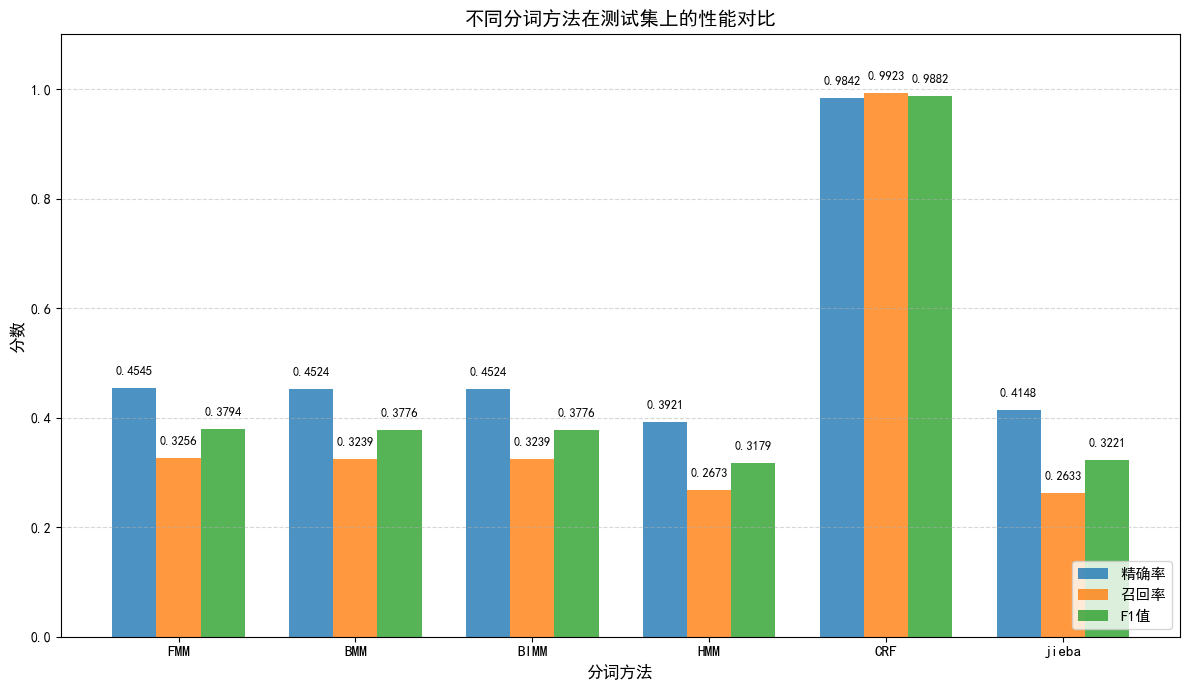

In [14]:
import matplotlib.pyplot as plt
import torch
from transformers import BertTokenizer, BertForTokenClassification
import numpy as np

def evaluate_segmentation(pred_segmentations, gold_segmentations):
    """
    计算测试集上的整体 P、R 和 F1 指标（支持多句子批量评估）
    Args:
        pred_segmentations: 预测的分词结果列表 [List[List[str]]]
        gold_segmentations: 真实的分词结果列表 [List[List[str]]]
    Return:
        整体 p, r, f1
    """
    assert len(pred_segmentations) == len(gold_segmentations), "预测和真实结果数量不匹配"
    
    total_correct = 0
    total_pred = 0
    total_gold = 0
    
    for pred, gold in zip(pred_segmentations, gold_segmentations):
        pred_set = set(pred)
        gold_set = set(gold)
        
        # 累计正确、预测总数、真实总数
        total_correct += len(pred_set & gold_set)
        total_pred += len(pred_set)
        total_gold += len(gold_set)
    
    # 计算指标
    p = total_correct / total_pred if total_pred > 0 else 0.0
    r = total_correct / total_gold if total_gold > 0 else 0.0
    f1 = 2 * p * r / (p + r) if (p + r) > 0 else 0.0
    
    return round(p, 4), round(r, 4), round(f1, 4)

print(f"测试集句子数量: {len(test_sentences)}")
print(f"第一个句子真实分词: {gold_segmentations[0]}")

methods = {
    "FMM": fmm_result,
    "BMM": bmm_result,
    "BIMM": bimm_result,
    "HMM": hmm_result,
    "CRF": crf_result,
    "jieba": jieba_result
}

print(f"{'方法':<10}{'精确率':<10}{'召回率':<10}{'F1值':<10}")
print("-" * 40)

methods_names = []
precisions, recalls, f1_scores = [], [], []

for method_name, pred_segs in methods.items():
    p, r, f = evaluate_segmentation(pred_segs, gold_segmentations)
    methods_names.append(method_name)
    precisions.append(p)
    recalls.append(r)
    f1_scores.append(f)
    print(f"{method_name:<10}{p:.4f}{' ' * 6}{r:.4f}{' ' * 6}{f:.4f}")

plt.figure(figsize=(12, 7))

# 设置x轴位置
x = np.arange(len(methods_names))
width = 0.25

# 绘制三组柱状图
plt.bar(x - width, precisions, width, label='精确率', alpha=0.8, color='#1f77b4')
plt.bar(x, recalls, width, label='召回率', alpha=0.8, color='#ff7f0e')
plt.bar(x + width, f1_scores, width, label='F1值', alpha=0.8, color='#2ca02c')

# 添加标题和标签
plt.title('不同分词方法在测试集上的性能对比', fontsize=14)
plt.xlabel('分词方法', fontsize=12)
plt.ylabel('分数', fontsize=12)
plt.ylim(0, 1.1)  # 扩展y轴范围，避免标签被截断

# 设置x轴标签
plt.xticks(x, methods_names, fontsize=11)

# 添加数值标签
for i, v in enumerate(precisions):
    plt.text(i - width, v + 0.02, f'{v:.4f}', ha='center', va='bottom', fontsize=9)
for i, v in enumerate(recalls):
    plt.text(i, v + 0.02, f'{v:.4f}', ha='center', va='bottom', fontsize=9)
for i, v in enumerate(f1_scores):
    plt.text(i + width, v + 0.02, f'{v:.4f}', ha='center', va='bottom', fontsize=9)

# 添加网格和图例
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.legend(loc='lower right', fontsize=11)

# 调整布局
plt.tight_layout()

# 显示图片
plt.show()